In [1]:
import numpy as np
import stim

In [242]:
L = 6
qubits_idxs = np.arange(2 * L**2).reshape(2 * L, L)

# Generate flat arrays of measurement qubit indices by type
x_meas_qubits_idxs = np.concat(
    [qubits_idxs[1::4, 0::2].flatten(), qubits_idxs[3::4, 1::2].flatten()]
)
z_meas_qubits_idxs = np.concat(
    [qubits_idxs[1::4, 1::2].flatten(), qubits_idxs[3::4, 0::2].flatten()]
)
data_qubits_idxs = qubits_idxs[0::2].flatten()

# Generate maps for finding adjacent qubit indices
up_left_shift_idx_map = np.roll(qubits_idxs, 1, 0).flatten()
up_right_shift_idx_map = np.roll(qubits_idxs, (1, -1), (0, 1)).flatten()
down_left_shift_idx_map = np.roll(qubits_idxs, -1, 0).flatten()
down_right_shift_idx_map = np.roll(qubits_idxs, (-1, -1), (0, 1)).flatten()

In [ ]:
def initialize_circuit():
    c = stim.Circuit()

    # Arrange qubits on grid
    for row in range(0, qubits_idxs.shape[0], 2):
        # Arrange data qubits
        for col in range(qubits_idxs.shape[1]):
            c.append("QUBIT_COORDS", qubits_idxs[row, col], [col, row / 2])
        # Arrange measurement qubits offset by (0.5, 0.5)
        for col in range(qubits_idxs.shape[1]):
            c.append(
                "QUBIT_COORDS", qubits_idxs[row + 1, col], [col + 0.5, row / 2 + 0.5]
            )

    # Reset data qubits
    c.append("R", data_qubits_idxs)
    c.append("TICK")

    # Reset X measurement qubits
    c.append("RX", x_meas_qubits_idxs)

    # Reset Z measurement qubits
    c.append("R", z_meas_qubits_idxs)
    c.append("TICK")

    # Apply stabilizers
    for map in [
        up_left_shift_idx_map,
        up_right_shift_idx_map,
        down_left_shift_idx_map,
        down_right_shift_idx_map,
    ]:
        for idx in x_meas_qubits_idxs:
            c.append("CX", [idx, map[idx]])
        for idx in z_meas_qubits_idxs:
            c.append("CX", [map[idx], idx])
        c.append("TICK")

    # Measure X stabilizers
    c.append("MX", x_meas_qubits_idxs)

    # Measure Z stabilizers
    for idx in z_meas_qubits_idxs:
        c.append("M", idx)
        # Add detectors on Z stabilizer measurements
        c.append("DETECTOR", stim.target_rec(-1), [idx % L + 0.5, idx // L * 0.5, 0])
    c.append("SHIFT_COORDS", [], [0, 0, 1])

    c.append("TICK")
    return c

In [244]:
def stabilizer_round():
    c = stim.Circuit()

    # Reset X measurement qubits
    c.append("RX", x_meas_qubits_idxs)

    # Reset Z measurement qubits
    c.append("R", z_meas_qubits_idxs)
    c.append("TICK")

    # Apply stabilizers
    for map in [
        up_left_shift_idx_map,
        up_right_shift_idx_map,
        down_left_shift_idx_map,
        down_right_shift_idx_map,
    ]:
        for idx in x_meas_qubits_idxs:
            c.append("CX", [idx, map[idx]])
        for idx in z_meas_qubits_idxs:
            c.append("CX", [map[idx], idx])
        c.append("TICK")

    # Measure stabilizers and add syndrome change detectors
    num_meas_qubits = x_meas_qubits_idxs.shape[0] + z_meas_qubits_idxs.shape[0]
    for idx in x_meas_qubits_idxs:
        c.append("MX", idx)
        c.append(
            "DETECTOR",
            [stim.target_rec(-1), stim.target_rec(-1 - num_meas_qubits)],
            [idx % L + 0.5, idx // L * 0.5, 0],
        )

    for idx in z_meas_qubits_idxs:
        c.append("M", idx)
        c.append(
            "DETECTOR",
            [stim.target_rec(-1), stim.target_rec(-1 - num_meas_qubits)],
            [idx % L + 0.5, idx // L * 0.5, 0],
        )
    c.append("SHIFT_COORDS", [], [0, 0, 1])
    c.append("TICK")

    return c

In [245]:
def logical_measurement():
    c = stim.Circuit()

    # Measure data qubits
    data_meas_record = np.zeros(data_qubits_idxs.max() + 1, dtype=object)
    for i, idx in enumerate(data_qubits_idxs):
        c.append("M", idx)
        data_meas_record[idx] = stim.target_rec(-1)

    # Add detectors to Z measurement qubits with surrounding data qubit measurements
    for i, idx in enumerate(z_meas_qubits_idxs):
        surrounding_data_qubits_idxs = np.array(
            [
                up_left_shift_idx_map[idx],
                up_right_shift_idx_map[idx],
                down_left_shift_idx_map[idx],
                down_right_shift_idx_map[idx],
            ]
        )

        # Calculate measurement record position of last z measurement qubit measurement
        z_meas_record = stim.target_rec(
            -data_qubits_idxs.shape[0] - z_meas_qubits_idxs.shape[0] + i
        )

        detector_targets_meas_records = np.concat(
            [[z_meas_record], data_meas_record[surrounding_data_qubits_idxs]]
        )

        c.append(
            "DETECTOR",
            detector_targets_meas_records,
            [idx % L + 0.5, idx // L * 0.5, 0],
        )

    # Measure observables
    diag_observable_data_qubits_idxs = qubits_idxs[0::2].diagonal()
    anti_diag_observable_data_qubits_idxs = np.fliplr(qubits_idxs[0::2]).diagonal()

    c.append(
        "OBSERVABLE_INCLUDE",
        data_meas_record[diag_observable_data_qubits_idxs],
        0,
    )
    c.append(
        "OBSERVABLE_INCLUDE",
        data_meas_record[anti_diag_observable_data_qubits_idxs],
        1,
    )

    return c

In [249]:
c = initialize_circuit() + 5 * stabilizer_round() + logical_measurement()

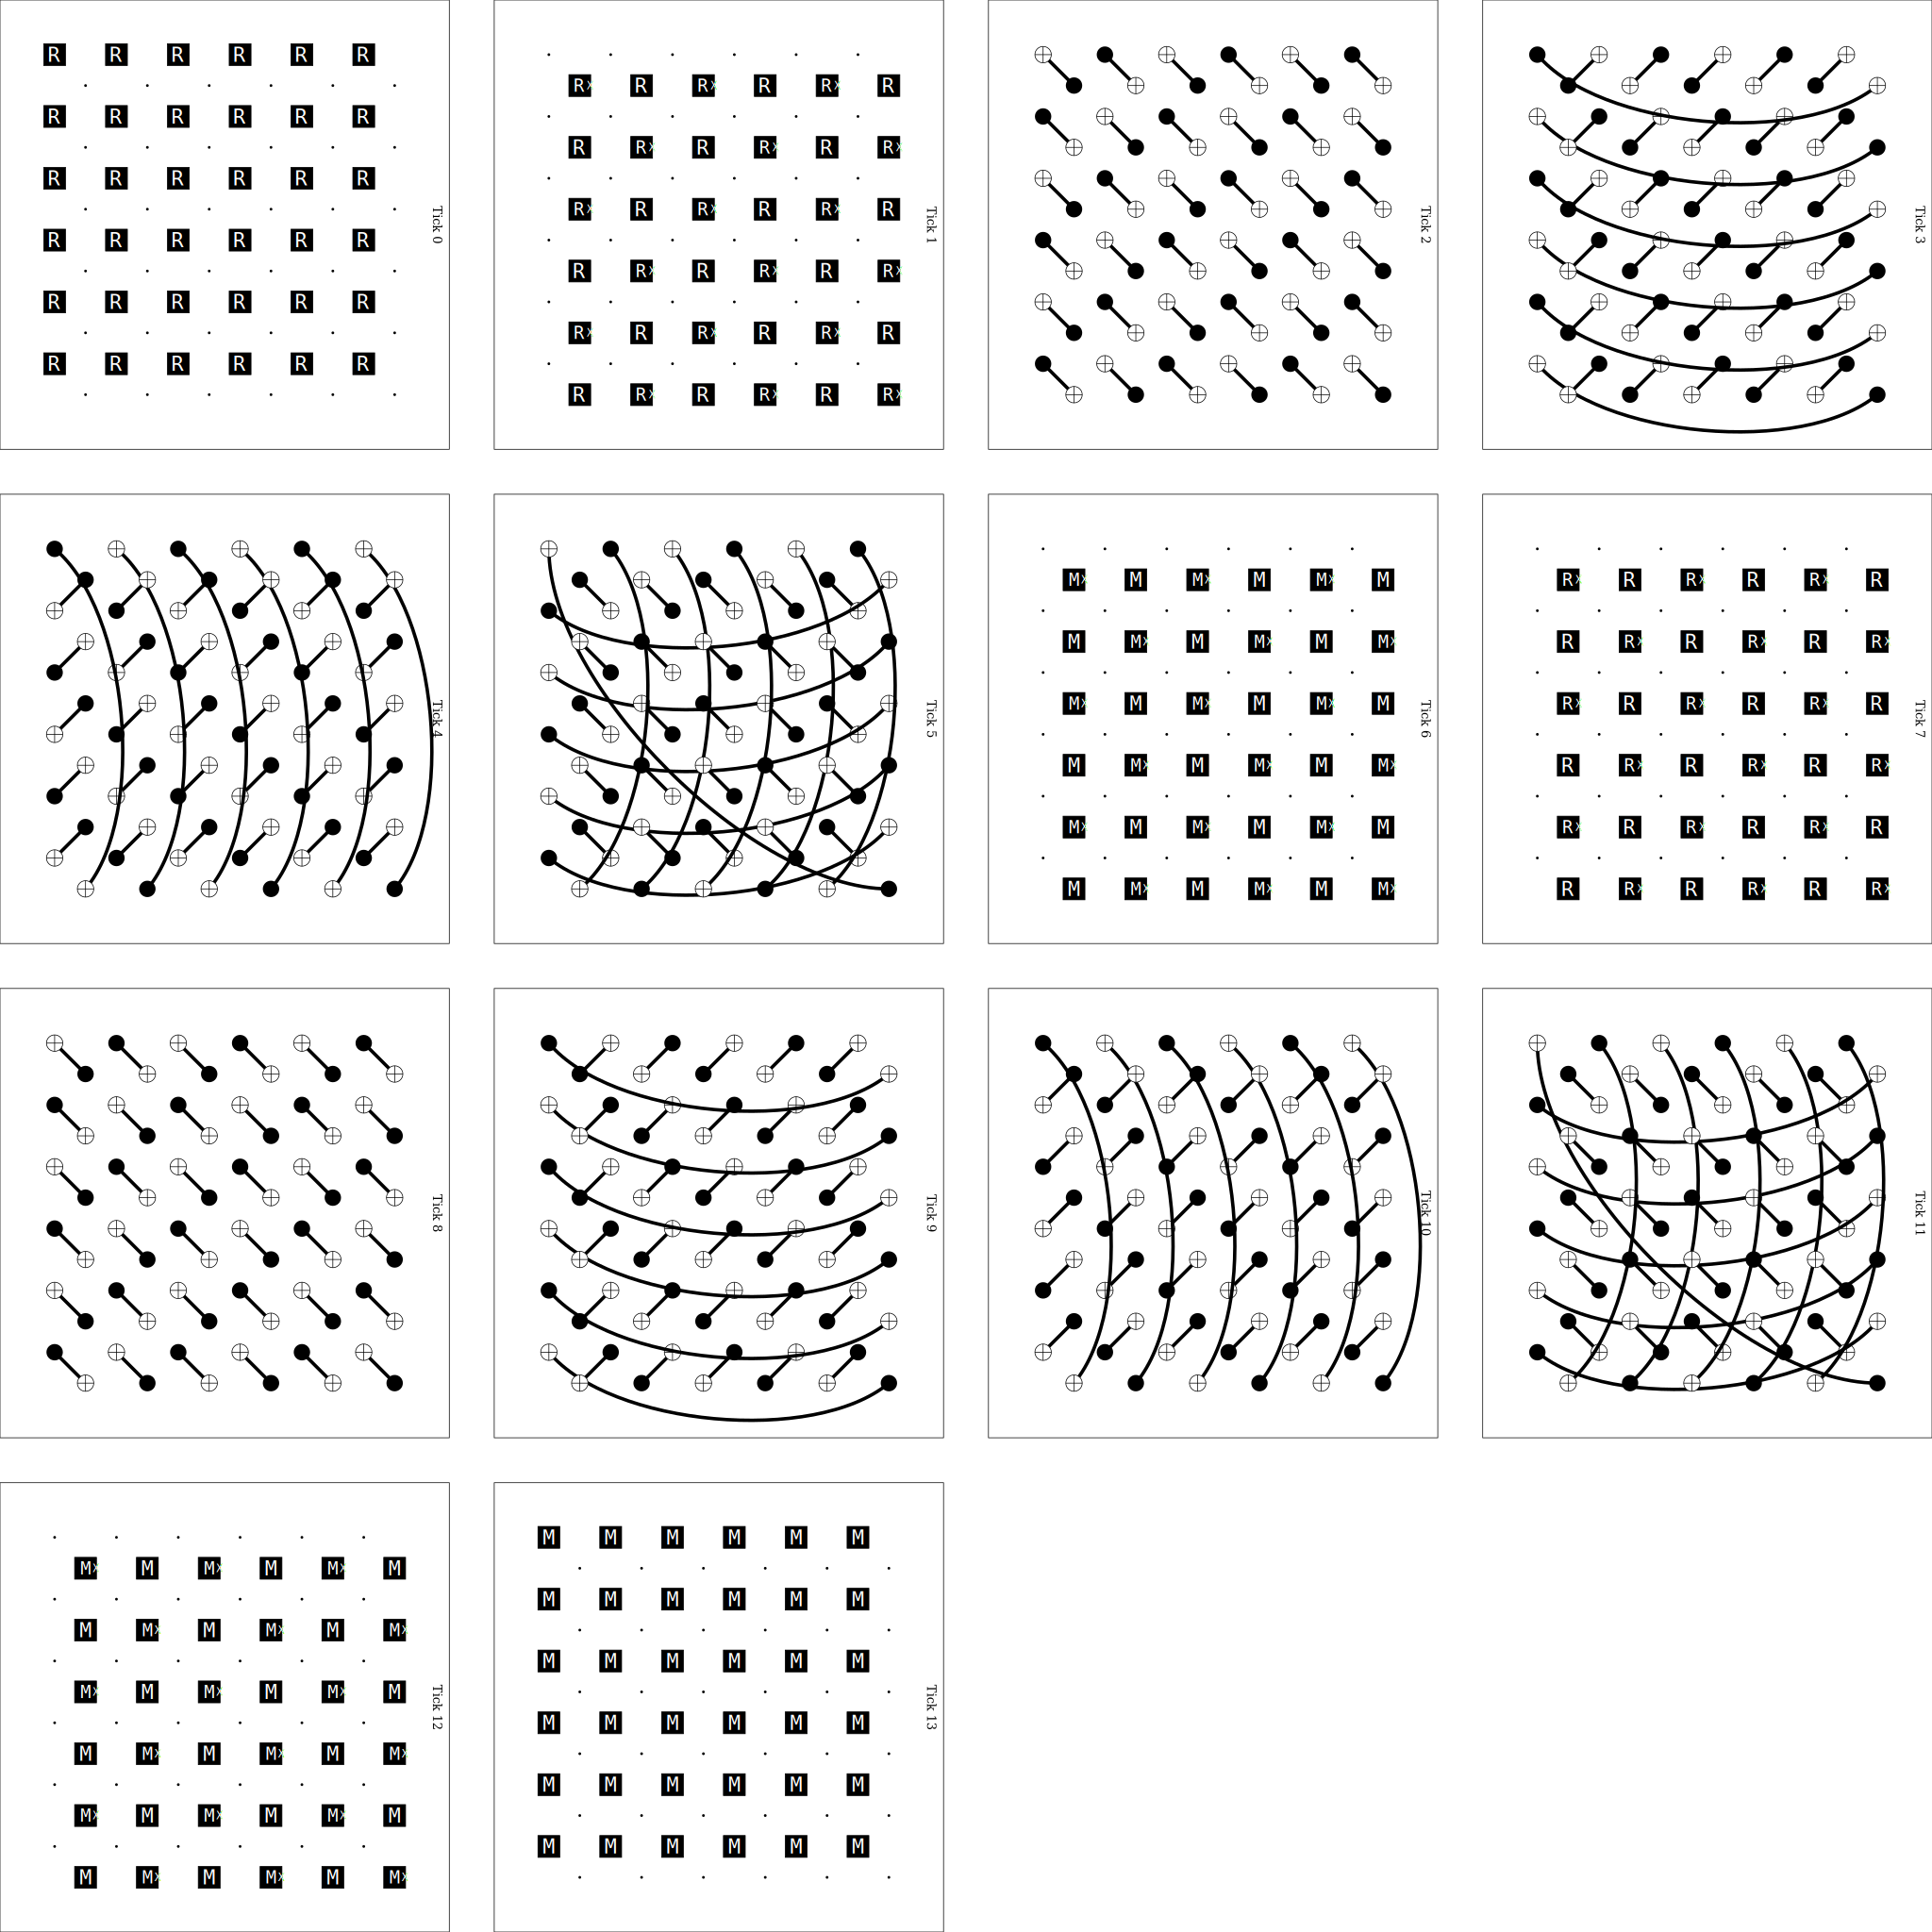

In [247]:
c.diagram("timeslice")

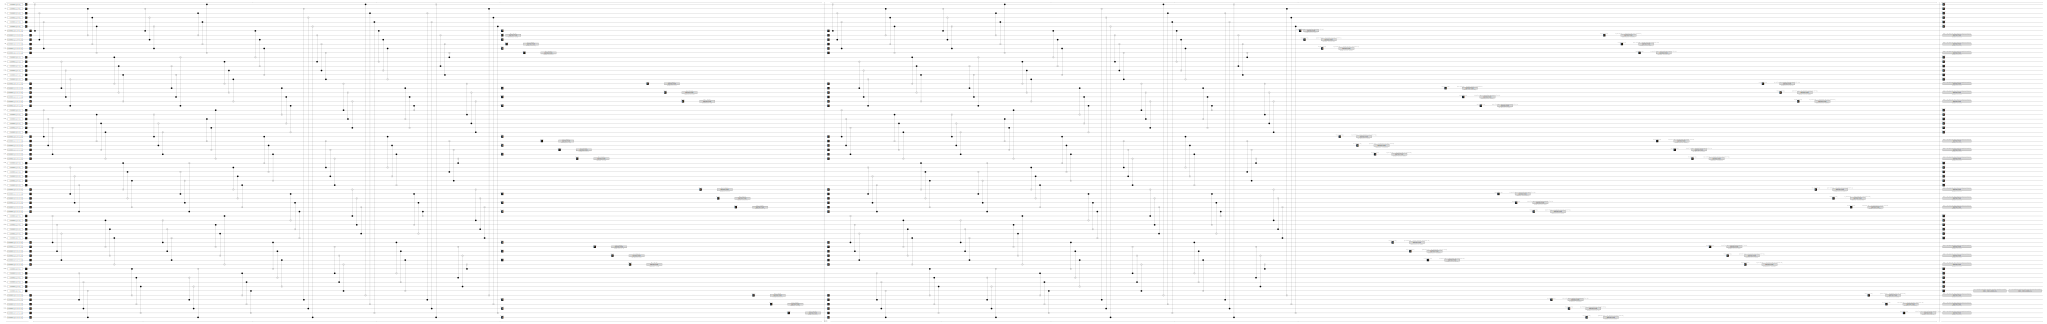

In [250]:
c.diagram("timeline")